In [1]:
import os
import pandas as pd
import geopandas as gpd
import cdsapi
from datetime import datetime, timedelta
import xarray as xr
import netCDF4
import zipfile
import shutil
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import pytz

# === SETTINGS ===
outage_file  = "data_collection_by_hollis/correlated_outage/extreme_outage_events.csv"
weather_dir  = "data_collection_by_hollis/correlated_outage/weather_output"
os.makedirs(weather_dir , exist_ok=True)

# Load outage events
df = pd.read_csv(outage_file)
print("Rows in outtage data: ", len(df))

Rows in outtage data:  427493


In [2]:
df = df.drop(columns=[
    col for col in df.columns if any(x in col for x in ["STATEFP", "COUNTYFP", "STATE_NAME", "NAME", "lat", "lon"])
])

# Load U.S. county shapefile from Census
shapefile_path = "data_collection_by_hollis/shapefiles/cb_2020_us_county_5m.zip"
counties = gpd.read_file(shapefile_path)
# counties["lat"] = counties.geometry.centroid.y
# counties["lon"] = counties.geometry.centroid.x

# # Re-project to a U.S.-appropriate planar CRS
# counties = counties.to_crs(epsg=5070)
# counties["county_lat"] = counties.geometry.centroid.to_crs(epsg=4326).y
# counties["county_lon"] = counties.geometry.centroid.to_crs(epsg=4326).x
# Re-project to U.S.-appropriate CRS
counties = counties.to_crs(epsg=5070)

# Then compute lat/lon from reprojected centroids
centroids = counties.geometry.centroid.to_crs(epsg=4326)
counties["county_lat"] = centroids.y
counties["county_lon"] = centroids.x

# Rename to match clean merge keys
counties = counties.rename(columns={
    "NAME": "county",
    "STATE_NAME": "state"
})
counties = counties.drop_duplicates(subset=["state", "county"])

df["state"] = df["state"].str.strip().str.lower()
df["county"] = df["county"].str.strip().str.lower()
counties["state"] = counties["state"].str.strip().str.lower()
counties["county"] = counties["county"].str.strip().str.lower()

# Merge on lowercase standardized fields
df = df.merge(
    counties[["state", "county", "county_lat", "county_lon"]],
    on=["state", "county"],
    how="left"
)
print("Rows after merge:", len(df))
counties[['state', 'county', 'county_lat', 'county_lon']].to_csv("county_centroids.csv", index=False)

df = df.reset_index(drop=True)


Rows after merge: 427493


In [3]:
def unzip_and_collect(zip_path):
    folder = os.path.dirname(zip_path)
    if not zipfile.is_zipfile(zip_path):
        return [zip_path]  # already .nc or uncompressed

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(folder)
        extracted = [os.path.join(folder, f) for f in zip_ref.namelist()]
    return [f for f in extracted if f.endswith(".nc") or f.endswith(".grib")]

In [4]:
def clean_downloaded_nc_files(keep_path, extra_paths):
    for path in extra_paths:
        if os.path.exists(path) and path != keep_path:
            try:
                os.remove(path)
                print(f"🗑️ Deleted extra file: {path}")
            except Exception as e:
                print(f"⚠️ Could not delete: {path}\n   {e}")


In [5]:
def download_hourly_weather(lat, lon, datetime_str, event_index, save_folder):
    tf = TimezoneFinder()
    tz_name = tf.timezone_at(lat=lat, lng=lon)
    tz = pytz.timezone(tz_name)
    target_datetime_local = pd.to_datetime(datetime_str)
    target_datetime = tz.localize(target_datetime_local).astimezone(pytz.utc)
    start_datetime = target_datetime - timedelta(hours=47)

    # 🔥 FINAL file path for event (create immediately)
    final_file = os.path.join(
        save_folder,
        f"event_{event_index}_{target_datetime.strftime('%Y-%m-%d_%H-%M')}.nc"
    )

    # 🔥 EARLY EXIT if final file already exists
    if os.path.exists(final_file):
        print(f"✅ Final 48-hour file already exists, skipping event {event_index}: {final_file}")
        return final_file

    area = [round(float(lat)+0.1, 4), round(float(lon)-0.1, 4),
            round(float(lat)-0.1, 4), round(float(lon)+0.1, 4)]

    variables_by_type = {
        'instant': [
            '2m_temperature', '2m_dewpoint_temperature', 'surface_pressure',
            '10m_u_component_of_wind', '10m_v_component_of_wind',
            'instantaneous_10m_wind_gust', 'total_column_rain_water',
            'boundary_layer_height'
        ],
        'accum': [
            'total_precipitation', 'snowfall',
            'surface_latent_heat_flux', 'surface_net_solar_radiation'
        ],
    }

    temp_files = []

    def fetch_and_open(day, offset, var_list, step_type):
        year, month, day_val = day.year, day.month, day.day
        tag = f"event_{event_index}{day.strftime('%Y-%m-%d')}_D-{offset}{step_type}.nc"
        out_path = os.path.join(save_folder, tag)

        if not os.path.exists(out_path):
            print(f"\n📦 Downloading: {out_path}")
            client = cdsapi.Client()
            client.retrieve(
                'reanalysis-era5-single-levels',
                {
                    'product_type': 'reanalysis',
                    'format': 'netcdf',
                    'variable': var_list,
                    'year': year,
                    'month': month,
                    'day': day_val,
                    'time': [f"{h:02}:00" for h in range(24)],
                    'area': area,
                },
                out_path
            )
        else:
            print(f"📦 Already downloaded: {out_path}")

        temp_files.append(out_path)
        return xr.open_dataset(out_path)

    all_datasets = []

    for offset in [2, 1, 0]:
        date = target_datetime.date() - timedelta(days=offset)
        for step_type, vars in variables_by_type.items():
            try:
                ds = fetch_and_open(date, offset, vars, step_type)
                all_datasets.append(ds.load())
                ds.close()
            except Exception as e:
                print(f"⚠ Failed to fetch or load for {date} {step_type}: {e}")

    if all_datasets:
        time_dim = 'time' if 'time' in all_datasets[0].dims else 'valid_time'
        merged = xr.merge(all_datasets)
        merged = merged.sortby(time_dim)
        unique_times = ~merged[time_dim].to_index().duplicated()
        merged = merged.isel({time_dim: unique_times})

        final = merged.sel({
            time_dim: slice(
                start_datetime.replace(tzinfo=None),
                target_datetime.replace(tzinfo=None)
            )
        })

        final.to_netcdf(final_file)
        print(f"✅ Saved 48-hour data: {final_file}")

        # 🧹 Clean up temporary downloaded files
        for f in temp_files:
            try:
                os.remove(f)
                print(f"🗑 Deleted temp file: {f}")
            except Exception as e:
                print(f"⚠ Could not delete {f}: {e}")

        return final_file

    print(f"❌ No valid datasets found for event {event_index}")
    return None

In [ ]:
# NEED TO CONVERT TO UTC
df = df.reset_index(drop=True)

for i, row in df.iterrows():
    # print(i)
    try:
        if pd.isnull(row['start_time']):
            continue
        # ⏱️ Round down to nearest hour
        start_time_floor = pd.to_datetime(row['start_time']).floor("h")

        lat, lon = row['county_lat'], row['county_lon']
        download_hourly_weather(lat, lon, start_time_floor, i, 'data_collection_by_hollis/correlated_outage/weather_output')

    except Exception as e:
        print(f"❌ Failed event {i} ({row['county']}): {e}")
    #break


✅ Final 48-hour file already exists, skipping event 0: data_collection_by_hollis/correlated_outage/weather_output\event_0_2014-11-24_15-00.nc


In [ ]:
# df = df.reset_index(drop=True)
# print(df.shape)
# print(df.head(3))
# print(df.index)
for i in reversed(df.index):
    row = df.loc[i]
    #print(i)
    try:
        if pd.isnull(row['start_time']):
            continue
        # ⏱️ Round down to nearest hour
        start_time_floor = pd.to_datetime(row['start_time']).floor("h")

        lat, lon = row['county_lat'], row['county_lon']
        download_hourly_weather(lat, lon, start_time_floor, i, 'data_collection_by_hollis/correlated_outage/weather_output')

    except Exception as e:
        print(f"❌ Failed event {i} ({row['county']}): {e}")
    #break

✅ Final 48-hour file already exists, skipping event 427492: data_collection_by_hollis/correlated_outage/weather_output\event_427492_2023-07-30_23-00.nc


b'\x89HDF\r\n\x1a\n\x02\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x11i\x01\x00\x00\x00\x00\x000\x00\x00\x00\x00\x00\x00\x00\x16\xe8\xdc\x19OHDR\x02\r\xb9\x02\x02"\x00\x00\x00\x00\x00\x03\x13\x00\x00\x00\x00\x00\x00\x00\xa7\x84\x00\x00\x00\x00\x00\x00lo\x00\x00\x00\x00\x00\x009\x85\x00\x00\x00\x00\x00\x00\n\x02\x00\x01\x00\x00\x00\x00\x10\x10\x00\x00\x00\x00\x01\x04\x00\x00\x00\x00\x00\x00M\x00\x00\x00\x00\x00\x00\x00\x0c%\x00\x00\x00\x00\x03\x00\x0c\x00\x08\x00\x04\x00\x00GRIB_centre\x00\x13\x00\x00\x00\x04\x00\x00\x00\x02\x00\x00\x00ecmf\x0c^\x00\x00\x01\x00\x03\x00\x17\x00\x08\x00\x04\x00\x00GRIB_centreDescription\x00\x13\x00\x00\x002\x00\x00\x00\x02\x00\x00\x00European Centre for Medium-Range Weather Forecasts\x0c@\x00\x00\x02\x00\x03\x00\x0f\x00\x0c\x00\x14\x00\x00GRIB_subCentre\x00\x10'
data_collection_by_hollis/correlated_outage/weather_output/event_4359872023-07-3023-00.nc size: 92433 bytes
1.7.2
{'netcdf4': <NetCDF4BackendEntrypoint>
  Open net

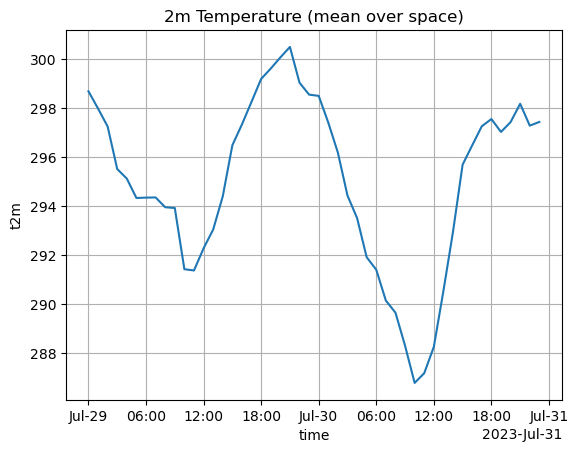

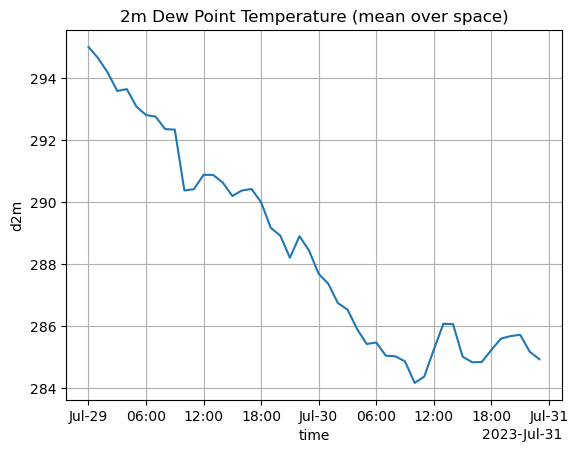

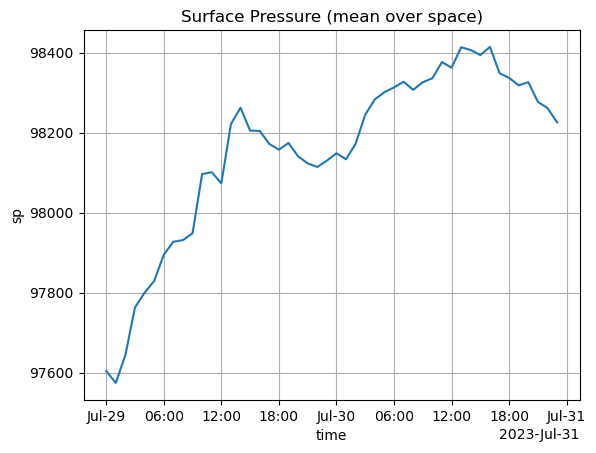

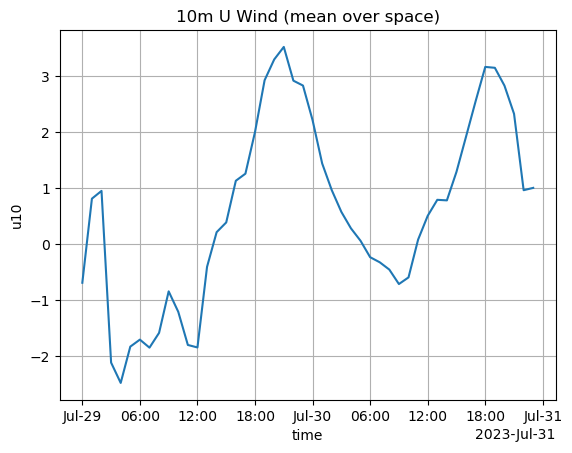

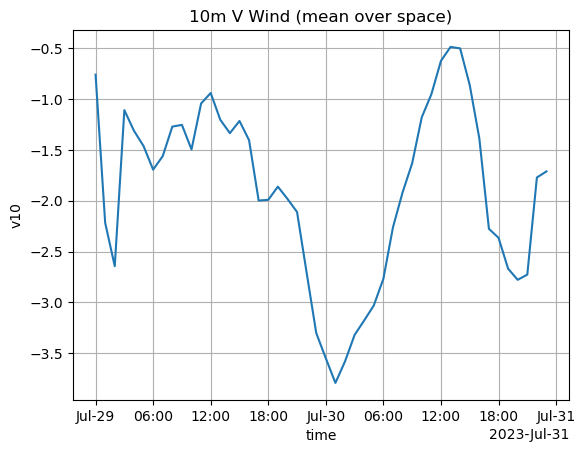

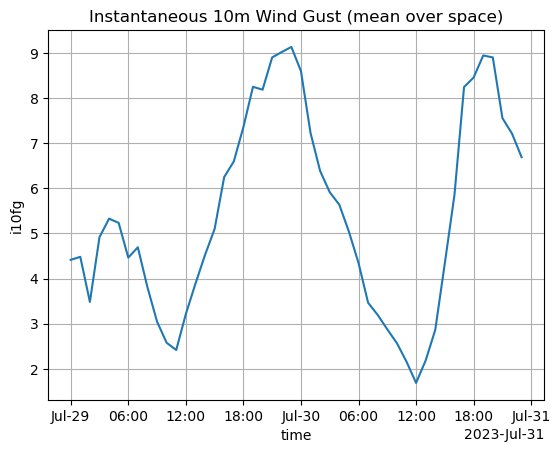

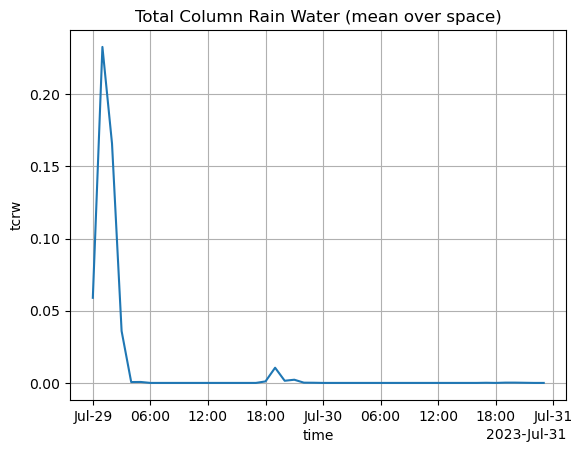

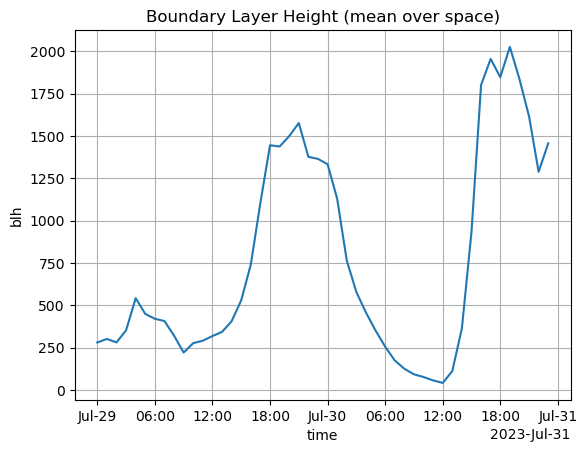

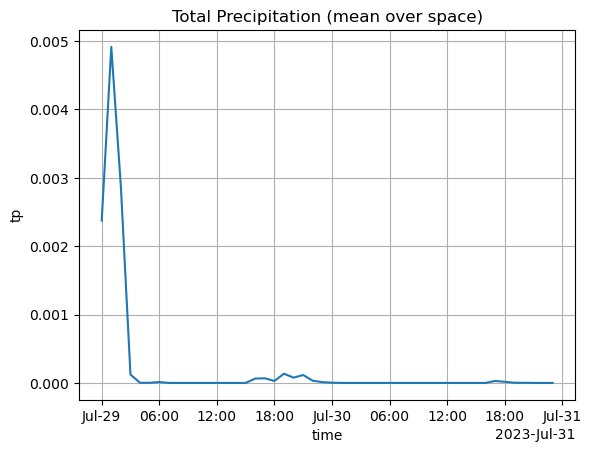

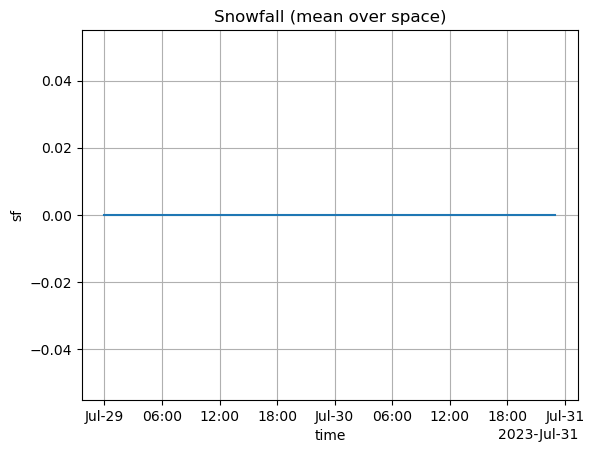

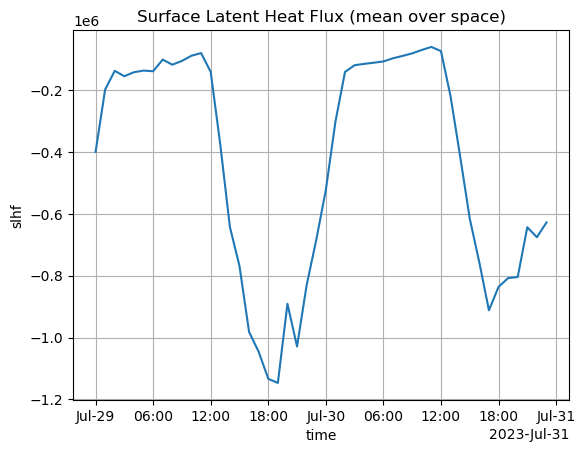

In [9]:
import matplotlib.pyplot as plt

#file = "data_collection_by_hollis/correlated_outage/weather_output/event_0_2014-11-24_15-00.nc"
file = "data_collection_by_hollis/correlated_outage/weather_output/event_4359872023-07-3023-00.nc"
xr.open_dataset(file, engine="h5netcdf")

with open(file, "rb") as f:
    head = f.read(512)
    print(head[:300])

file_path = file
print(f"{file_path} size: {os.path.getsize(file_path)} bytes")

print(netCDF4.__version__)
print(xr.backends.list_engines())

ds = xr.open_dataset(
    file,
    engine="netcdf4"
)

print(ds)

# Dictionary of variable names and titles
plot_vars = {
    't2m': '2m Temperature',
    'd2m': '2m Dew Point Temperature',
    'sp': 'Surface Pressure',
    'u10': '10m U Wind',
    'v10': '10m V Wind',
    'i10fg': 'Instantaneous 10m Wind Gust',
    'tcrw': 'Total Column Rain Water',
    'blh': 'Boundary Layer Height',
    'tp': 'Total Precipitation',
    'sf': 'Snowfall',
    'slhf': 'Surface Latent Heat Flux',
    'avg_snswrf': 'Average Net Short-Wave Radiation Flux'
}

for var, title in plot_vars.items():
    if var in ds:
        plt.figure()
        ds[var].mean(dim=['latitude', 'longitude']).plot()
        plt.title(f"{title} (mean over space)")
        plt.grid(True)
    else:
        print(f"⚠️ Variable '{var}' not found in dataset.")
ds.close()


In [ ]:
with open(file_path, "rb") as f:
    magic = f.read(4)
    print("Magic bytes:", magic)

print(ds)
print(ds.variables)
print(ds.attrs) 

Magic bytes: b'\x89HDF'
<xarray.Dataset> Size: 1kB
Dimensions:     (valid_time: 48, latitude: 1, longitude: 1)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 384B 2014-11-22T16:00:00 ... 2014...
  * latitude    (latitude) float64 8B 36.27
  * longitude   (longitude) float64 8B -90.52
    expver      (valid_time) <U4 768B ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 192B 0.0 ... 0.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-24T02:44 GRIB to CDM+CF via cfgrib-0.9.1...
Frozen({'tp': <xarray.Variable (valid_time: 48, latitude: 1, longitude: 1)> Size: 192B
array([[[0.000000e+00]],

       [[1.510022e-05]],

       [[0.000000e+00]],

       [[0.000000e+00]],